In [460]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy

fusion_dir = '/home/mila/b/baldelld/scratch/LLM4CAD/cadmium/data/Fusion360/r1.0.1/reconstruction'
uids_json = os.listdir('/home/mila/b/baldelld/scratch/LLM4CAD/cadmium/data/fusion360/Fusion360/r1.0.1/reconstruction')

files = [f for f in os.listdir(fusion_dir) if len(f.split('_')) == 3]
#files = np.array(os.listdir(fusion_dir))
file_types = np.unique(list(map(lambda x: x.split('.')[-1], files)))
uids_render = np.unique(list(map(lambda x: x.split('.')[0], files)))

uids_inter = set(uids_render).intersection(set(uids_json))
print('Number of jsons:', len(uids_json))
print('Number of renders:', len(uids_render))
print('File types:', file_types)

Number of jsons: 8307
Number of renders: 8625
File types: ['json' 'obj' 'png' 'smt' 'step']


In [1]:
import os
len(os.listdir('/home/mila/b/baldelld/scratch/LLM4CAD/cadmium/data/fusion360_rgb_images'))

8625

In [453]:
uids_json[0], uids_render[0]

('100155_57ec5fc6_000', np.str_('100106_7f144e5b_0000'))

In [452]:
uids_inter = [uid for uid in uids_render if uid[:-1] in uids_json]
len(uids_inter)

8445

In [456]:
while True:
    idx = np.random.randint(0, len(uids_json))
    if np.sum(np.array([x[:-1] for x in uids_render]) == uids_json[idx]) > 1:
        break


In [458]:
uids_json[idx], [x for x in uids_render if x.startswith(uids_json[idx])]

('53448_2f7c767c_001',
 [np.str_('53448_2f7c767c_0016'), np.str_('53448_2f7c767c_0018')])

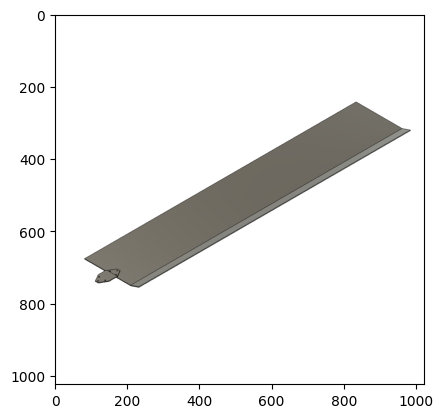

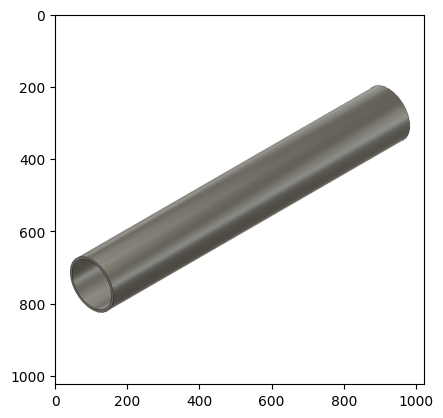

In [459]:
img_path_template = '/home/mila/b/baldelld/scratch/LLM4CAD/cadmium/data/Fusion360/r1.0.1/reconstruction/{uid}.png'

for uid in [x for x in uids_render if x.startswith(uids_json[idx])]:
    img_path = img_path_template.format(uid=uid)
    plt.imshow(plt.imread(img_path))
    plt.show()

In [ ]:
df = pd.DataFrame(columns=['uid_render', 'uid_json'], 
                  data=[(uid, uid_json) for uid in uids for uid_json in uids_json if uid in uid_json])

,uid,uid_json


In [81]:
len(uids), len(uids_lc), len(uid_inter)

(8625, 4610, 0)

In [465]:
idx = np.random.randint(0, len(uids))
uid = uids[idx]

# uid = '22734_f6bad9f7_0023'

OBJ_PATH = os.path.join(fusion_dir, f'{uid}.obj')
OUTPUT_PARENT_DIR = "/home/mila/b/baldelld/scratch/LLM4CAD/cadmium/data/fusion360_rgb_images/"
OUTPUT_DIR = os.path.join(OUTPUT_PARENT_DIR, uid)
CAMERA_DATA_PATH = os.path.join(OUTPUT_DIR, f'camera_data.json')

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [466]:
import bpy
import json
import math
import mathutils
import os

# ──────────────────────────────────────────────────────────────────────────────
# 2) Minimal JSON template from previous step (place it in this variable)
#    with only the "origin" slots left as placeholders (we'll overwrite them).
# ──────────────────────────────────────────────────────────────────────────────
template_camera_data = {
    "universal": {
        "x_fov": 0.8575560450553894,
        "y_fov": 0.8575560450553894,
        "focal_length": 35.0
    },
    "cameras": {
        "top":    {"origin": [0,0,0], "x":[1.3333,0,0],    "y":[0,-1.3333,0],    "z":[0,0,-1.3333]},
        "bottom": {"origin": [0,0,0], "x":[-1.3333,0,0],   "y":[0,-1.3333,0],    "z":[0,0,1.3333]},
        "000":    {"origin": [0,0,0], "x":[0,1.3333,0],    "y":[0.6667,0,-1.1547],"z":[-1.1547,0,-0.6667]},
        "001":    {"origin": [0,0,0], "x":[-0.9428,0.9428,0],"y":[0.4714,0.4714,-1.1547],"z":[-0.8165,-0.8165,-0.6667]},
        "002":    {"origin": [0,0,0], "x":[-1.3333,8e-17,0],"y":[4e-17,0.6667,-1.1547],"z":[-7e-17,-1.1547,-0.6667]},
        "003":    {"origin": [0,0,0], "x":[-0.9428,-0.9428,0],"y":[-0.4714,0.4714,-1.1547],"z":[0.8165,-0.8165,-0.6667]},
        "004":    {"origin": [0,0,0], "x":[0,-1.3333,0],"y":[-0.6667,0,-1.1547],"z":[1.1547,0,-0.6667]},
        "005":    {"origin": [0,0,0], "x":[0.9428,-0.9428,0],"y":[-0.4714,-0.4714,-1.1547],"z":[0.8165,0.8165,-0.6667]},
        "006":    {"origin": [0,0,0], "x":[1.3333,0,0],"y":[0,-0.6667,-1.1547],"z":[0,1.1547,-0.6667]},
        "007":    {"origin": [0,0,0], "x":[0.9428,0.9428,0],"y":[0.4714,-0.4714,-1.1547],"z":[-0.8165,0.8165,-0.6667]},
    }
}

# ──────────────────────────────────────────────────────────────────────────────
# 3) Clean scene
# ──────────────────────────────────────────────────────────────────────────────
bpy.ops.object.select_all(action='SELECT')
bpy.ops.object.delete(use_global=False)

# ──────────────────────────────────────────────────────────────────────────────
# 4) Import the OBJ
# ──────────────────────────────────────────────────────────────────────────────
bpy.ops.wm.obj_import(filepath=OBJ_PATH)
obj = bpy.context.selected_objects[0]

# ──────────────────────────────────────────────────────────────────────────────
# 5) Recenter at world origin
# ──────────────────────────────────────────────────────────────────────────────
bpy.context.view_layer.objects.active = obj
#bpy.ops.object.origin_set(type='ORIGIN_CENTER_OF_VOLUME', center='BOUNDS')
bpy.ops.object.origin_set(type='ORIGIN_GEOMETRY',      center='BOUNDS')
obj.location = (0, 0, 0)

# ──────────────────────────────────────────────────────────────────────────────
# 6) Compute half‐extents from bounding box
# ──────────────────────────────────────────────────────────────────────────────
bbox_world = [obj.matrix_world @ mathutils.Vector(c) for c in obj.bound_box]
min_corner = mathutils.Vector((
    min(v.x for v in bbox_world),
    min(v.y for v in bbox_world),
    min(v.z for v in bbox_world),
))
max_corner = mathutils.Vector((
    max(v.x for v in bbox_world),
    max(v.y for v in bbox_world),
    max(v.z for v in bbox_world),
))
half_extents = (max_corner - min_corner) / 2.0

# ──────────────────────────────────────────────────────────────────────────────
# 7) Compute camera distances
#    - Top & bottom: ensure both x‐ and y‐extents fit in their FOV
#    - “Around” views: same horizontal distance, but shoot at mid‐height
# ──────────────────────────────────────────────────────────────────────────────
camera_data = deepcopy(template_camera_data)
x_fov = camera_data["universal"]["x_fov"]
y_fov = camera_data["universal"]["y_fov"]
# distance so that half‐width & half‐depth both fit
d_top = max(
    half_extents.x / math.tan(x_fov/2),
    half_extents.y / math.tan(y_fov/2),
    half_extents.z
)
# We'll use the same radial distance for the 8 side‐views:
radius = d_top

# ──────────────────────────────────────────────────────────────────────────────
# 8) Fill in the origins
# ──────────────────────────────────────────────────────────────────────────────
# Top / bottom
camera_data["cameras"]["top"]["origin"]    = [0.0,          0.0,          d_top]
camera_data["cameras"]["bottom"]["origin"] = [0.0,          0.0,         -d_top]

# Around views: keys "000" .. "007"
for i in range(8):
    angle = 2*math.pi * i / 8
    x = radius * math.cos(angle)
    y = radius * math.sin(angle)
    z = half_extents.z
    key = f"{i:03d}"
    camera_data["cameras"][key]["origin"] = [x, y, z]

# ──────────────────────────────────────────────────────────────────────────────
# 9) save the camera data
# ──────────────────────────────────────────────────────────────────────────────

with open(os.path.join(OUTPUT_DIR, f'camera_data.json'), 'w') as f:
    json.dump(camera_data, f, indent=4)
    print(f"Camera data saved to {CAMERA_DATA_PATH}")

OBJ import of '55574_19c6c72e_0000.obj' took 6.3 ms
Camera data saved to /home/mila/b/baldelld/scratch/LLM4CAD/cadmium/data/fusion360_rgb_images/55574_19c6c72e_0000/camera_data.json


In [467]:
import bpy
import json
import mathutils
import os

# 1) Make sure the Cycles addon is loaded
if 'cycles' not in bpy.context.preferences.addons:
    bpy.ops.preferences.addon_enable(module='cycles')

# 2) Choose your compute API ('CUDA', 'OPTIX', 'OPENCL' or 'NONE')
prefs = bpy.context.preferences.addons['cycles'].preferences
prefs.compute_device_type = 'CUDA'    # or 'OPTIX' if you have an NVIDIA RTX card
# prefs.compute_device_type = 'OPENCL'  # for AMD cards

# 4) Tell Cycles to render on the GPU
bpy.context.scene.cycles.device = 'GPU'

# -----------------------------------------------------------------------------
# 1. User‐defined paths & parameters
# -----------------------------------------------------------------------------
# OBJ_PATH          = "/path/to/your_object.obj"
# CAMERA_DATA_PATH  = "/path/to/camera_data.json"
# OUTPUT_DIR        = "/path/to/output/renders"

offset_distance = 0   # extra shift along camera forward vector
multiplier      = 1.7  # scale factor on the precomputed origins
light_energy = 7000

# -----------------------------------------------------------------------------
# 2. Clean the scene
# -----------------------------------------------------------------------------
bpy.ops.object.select_all(action='SELECT')
bpy.ops.object.delete(use_global=False)

# -----------------------------------------------------------------------------
# 3. Load camera parameters
# -----------------------------------------------------------------------------
with open(CAMERA_DATA_PATH, 'r') as f:
    camera_data = json.load(f)

univ  = camera_data['universal']
views = camera_data['cameras']

# -----------------------------------------------------------------------------
# 4. Import the object (OBJ)
# -----------------------------------------------------------------------------
bpy.ops.wm.obj_import(filepath=OBJ_PATH)
obj = bpy.context.selected_objects[0]

# -----------------------------------------------------------------------------
# 5. Recenter the mesh at world origin
# -----------------------------------------------------------------------------
bpy.context.view_layer.objects.active = obj
bpy.ops.object.origin_set(type='ORIGIN_GEOMETRY',      center='BOUNDS')
#bpy.ops.object.origin_set(type='ORIGIN_CENTER_OF_VOLUME', center='BOUNDS')
obj.location = (0, 0, 0)

# ──────────────────────────────────────────────────────────────────────────────
# 5.5) Create a world‐origin empty for cameras to track
# ──────────────────────────────────────────────────────────────────────────────
scene = bpy.context.scene
cam_target = bpy.data.objects.new("CamTarget", None)
scene.collection.objects.link(cam_target)
cam_target.location = (0.0, 0.0, 0.0)

# -----------------------------------------------------------------------------
# 6. Assign a simple grey material
# -----------------------------------------------------------------------------
mat = bpy.data.materials.new(name="GreyMat")
mat.use_nodes = True

# Grab the Principled BSDF node
bsdf = mat.node_tree.nodes.get("Principled BSDF")

# Set base color
bsdf.inputs["Base Color"].default_value = (0.5, 0.5, 0.5, 1.0)

# Increase roughness for a duller, more diffuse look
bsdf.inputs["Roughness"].default_value = 0.05 # range 0.0 (smooth) to 1.0 (very rough)


if obj.data.materials:
    obj.data.materials[0] = mat
else:
    obj.data.materials.append(mat)


# -----------------------------------------------------------------------------
# 8. Render settings
# -----------------------------------------------------------------------------
scene = bpy.context.scene
scene.render.engine          = 'CYCLES'
scene.cycles.samples        = 32
scene.render.film_transparent = True
scene.render.resolution_x   = 512
scene.render.resolution_y   = 512

# turn on nodes for the world
world = scene.world
world.use_nodes = True
nodes = world.node_tree.nodes

# grab the existing Background node (created by default)
bg = nodes.get("Background")

# set it to pure white (1,1,1,1) and boost the strength
bg.inputs["Color"].default_value    = (1.0, 1.0, 1.0, 1.0)
bg.inputs["Strength"].default_value = 0.5   # ↑ increase until your object is evenly lit

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ──────────────────────────────────────────────────────────────────────────────
# 9) Loop over each view, place & track camera, render, clean up
# ──────────────────────────────────────────────────────────────────────────────
for view_name, params in views.items():
    # 1) create camera
    cam_data = bpy.data.cameras.new(name=f"Cam_{view_name}")
    cam_obj  = bpy.data.objects.new(name=f"Cam_{view_name}", object_data=cam_data)
    scene.collection.objects.link(cam_obj)

    # 2) compute & apply scaled/offset origin
    origin = mathutils.Vector(params['origin']) * multiplier
    forward = -mathutils.Vector(params['z']).normalized()
    origin += forward * offset_distance
    cam_obj.location = origin

    # 3) add a Track To constraint so the camera always points at our empty
    track = cam_obj.constraints.new(type='TRACK_TO')
    track.target     = cam_target
    track.track_axis = 'TRACK_NEGATIVE_Z'  # camera’s -Z points toward target
    track.up_axis    = 'UP_Y'              # Y-up for camera roll

    # 4) set FOV & focal length (universal parameters)
    cam_data.angle_x = univ['x_fov']
    cam_data.angle_y = univ['y_fov']
    cam_data.lens    = univ['focal_length']

    # 5) render
    scene.camera = cam_obj
    scene.render.filepath = os.path.join(OUTPUT_DIR, f"{view_name}.png")
    bpy.ops.render.render(write_still=True)

    # 6) cleanup camera
    bpy.data.objects.remove(cam_obj, do_unlink=True)
    bpy.data.cameras.remove(cam_data,   do_unlink=True)

OBJ import of '55574_19c6c72e_0000.obj' took 3.6 ms
Fra:1 Mem:29.27M (Peak 29.27M) | Time:00:00.13 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | 55574_19c6c72e_0000
Fra:1 Mem:29.34M (Peak 29.34M) | Time:00:00.13 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Initializing
Fra:1 Mem:29.16M (Peak 29.34M) | Time:00:00.13 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Waiting for render to start
Fra:1 Mem:29.16M (Peak 29.34M) | Time:00:00.13 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Loading render kernels (may take a few minutes the first time)
Fra:1 Mem:29.16M (Peak 49.71M) | Time:00:00.17 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Scene
Fra:1 Mem:29.16M (Peak 49.71M) | Time:00:00.17 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Shaders
Fra:1 Mem:29.24M (Peak 49.71M) | Time:00:00.18 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Procedurals
Fra:1 Mem:29.24M (Peak 49.71M) | Time:00:00.18 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Bac

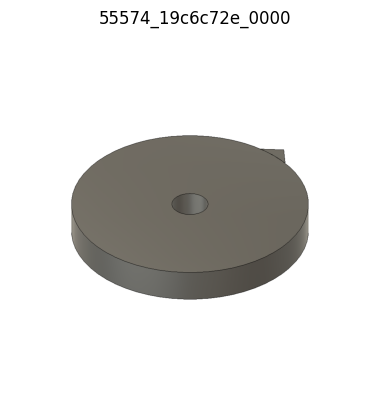

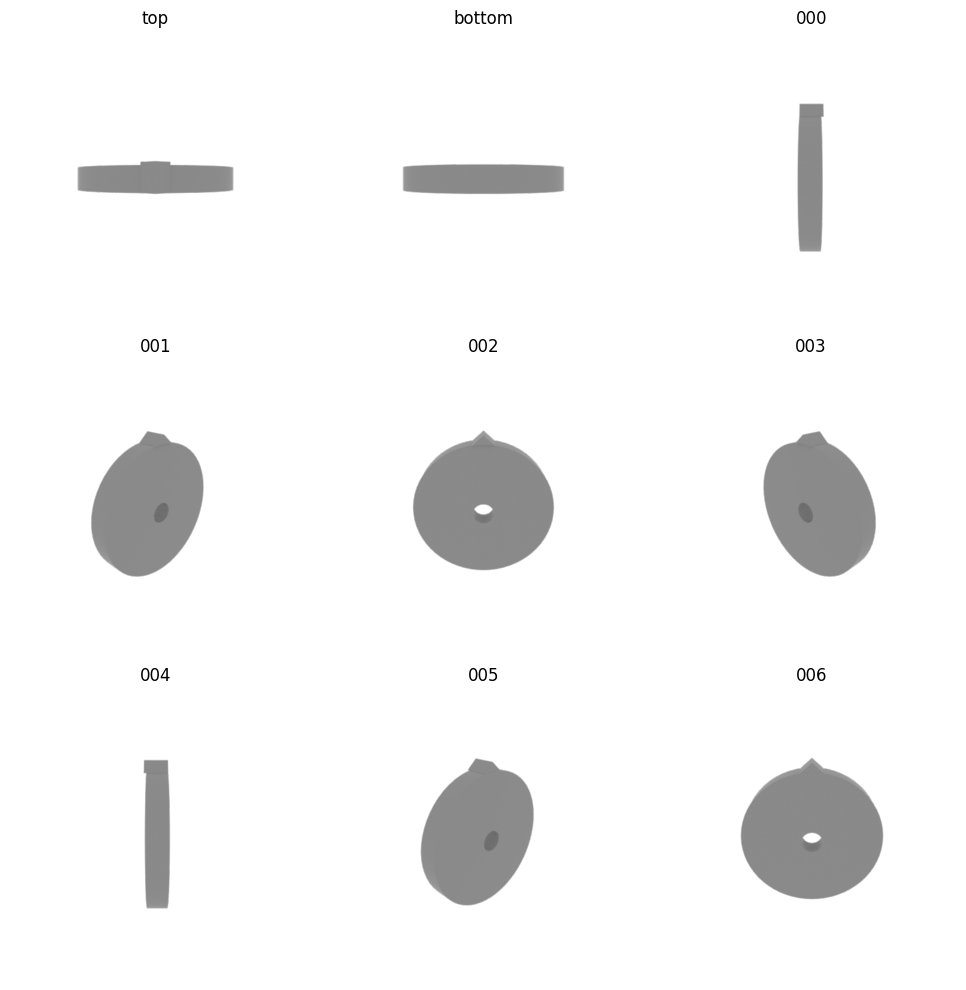

In [468]:
original_image_path = os.path.join(fusion_dir, f'{uid}.png')
# display it 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(original_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(uid)
plt.show()

# Plot all multi views in 3x3 grid
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for i, view in enumerate(['top', 'bottom', '000', '001', '002', '003', '004', '005', '006']):
    img = mpimg.imread(os.path.join(OUTPUT_DIR, f'{view}.png'))
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(view)
plt.tight_layout()
plt.show()



In [411]:
center

Vector((38.64729690551758, -69.20602416992188, 4.839408874511719))